In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import gensim

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Utils

In [2]:
import pickle

def savePickle(fn, var):
    pickle_out = open(fn+".pickle","wb")
    pickle.dump(var, pickle_out)
    pickle_out.close()

def loadPickle(fn):
    pickle_in = open(fn+".pickle","rb")
    var = pickle.load(pickle_in)
    pickle_in.close()
    return var

## Dataset used
URL: https://www.kaggle.com/snapcrack/all-the-news

The dataset was downloaded from Kaggle.

The dataset is split into three files named articles1.csv, articles2.csv and articles3.csv

In [3]:
#read data
data1 = pd.read_csv("data/articles1.csv", index_col=0).drop(["url", "author", "id", "date", "year", "month"], axis=1)
data2 = pd.read_csv("data/articles2.csv", index_col=0).drop(["url", "author", "id", "date", "year", "month"], axis=1)
data3 = pd.read_csv("data/articles3.csv", index_col=0).drop(["url", "author", "id", "date", "year", "month"], axis=1)
data = pd.concat([data1, data2, data3])
del data1, data2, data3
data.shape

(142570, 3)

#### Distribution of the data in 20 groups

In [4]:
data.groupby("publication").count().title.sort_values()

publication
Fox News                4354
Buzzfeed News           4854
Vox                     4947
Talking Points Memo     5213
National Review         6203
Business Insider        6757
Atlantic                7179
New York Times          7803
Guardian                8681
Reuters                10709
Washington Post        11114
CNN                    11488
NPR                    11992
New York Post          17493
Breitbart              23781
Name: title, dtype: int64

## Selecting a subset of data
The dataset contains 20 news groups, but only a subset of 5 news groups were used in this project due to lack of computational resources.

The five news groups were selected in such a way that the number of articles from each group remain approximately similar.

The five groups select are: "Guardian", "Reuters", "Washington Post", "CNN" and "NPR".

In [5]:
data = data[data.publication.isin(["Guardian", "Reuters", "Washington Post", "CNN", "NPR"])]
print("Shape of the dataset : ", data.shape)
data.head()

Shape of the dataset :  (53985, 3)


,title,publication,content
31592,Istanbul attack: Dozens killed at nightclub,CNN,Istanbul (CNN) At least 39 people were killed ...
31593,"Alabama, Clemson back in national title game",CNN,Atlanta (CNN) This season’s College Football P...
31594,New year celebrations ring in 2017,CNN,(CNN) Revelers on the United States’ west coa...
31595,Trump says he has inside information on hacking,CNN,"West Palm Beach, Florida (CNN) Donald Trump s..."
31596,3 dead in Texas plane crash collision,CNN,(CNN) Two small planes collided in Texas on S...


## Preprocess articles title and content

In [6]:
#checking if the data contains any na values
data.isna().sum()

title          1
publication    0
content        0
dtype: int64

In [7]:
#replacing na values with empty string 
data.fillna("", inplace=True)
data.isna().sum()

title          0
publication    0
content        0
dtype: int64

In [8]:
## Removing special characters, 
## Keeps all words, numbers and alphanumerics
def cleanObservations(text):
    #remove pumtuations and line change and tabs
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9 ]|\b\w{1}\b", " ", text)
    text = " ".join(re.sub(r"(^| )\d+\w+|(^| )\d+", " ", text).split())
    return removeStopWords_Lemm(text)

#remove stop words and lemmatize the words
lemmatizer = WordNetLemmatizer()
def removeStopWords_Lemm(text): 
    rsw = []
    stop_words = stopwords.words("english")
    for word in text.split():
        if word not in stop_words:
            rsw.append(lemmatizer.lemmatize(word))
    return " ".join(rsw)

def loadProcessedData():
    if os.path.exists("Data/processedData.pickle"):
        data = loadPickle("Data/processedData")
    else:
        data["PCon"] = data.content.apply(cleanObservations)
        data["PTit"] = data.title.apply(cleanObservations)
        data["PTitCon"] = data["PTit"] + " " + data["PCon"]
        data["word_count_content"] = data.PTitCon.apply(str.split).apply(len)
    return data

In [60]:
data = loadProcessedData()
data.drop(["title", "content"], axis=1, inplace=True)
data.head()

,publication,PCon,PTit,PTitCon,word_count_content
31592,CNN,istanbul cnn least people killed least wounded...,istanbul attack dozen killed nightclub,istanbul attack dozen killed nightclub istanbu...,550
31593,CNN,atlanta cnn season college football playoff ce...,alabama clemson back national title game,alabama clemson back national title game atlan...,503
31594,CNN,cnn reveler united state west coast cheered ad...,new year celebration ring,new year celebration ring cnn reveler united s...,507
31595,CNN,west palm beach florida cnn donald trump said ...,trump say inside information hacking,trump say inside information hacking west palm...,333
31596,CNN,cnn two small plane collided texas saturday ki...,dead texas plane crash collision,dead texas plane crash collision cnn two small...,62


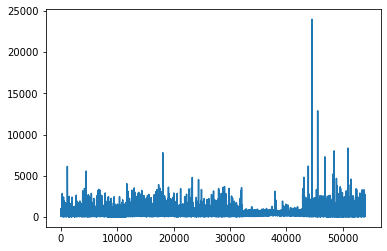

In [61]:
plt.plot(range(data.shape[0]), data.word_count_content)

The plot above shows that majority of the articles are of length less than 5000 words. There are a few outliers that have more than 10,000 words.

## Split Data into train, validation and test

In [62]:
train, test, _, _ =  train_test_split(data, data.publication, test_size=0.20, random_state=1234)
train, validation, _, _ =  train_test_split(train, train.publication, test_size=0.20, random_state=1234)
train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
del data
train.shape, validation.shape, test.shape

((34550, 5), (8638, 5), (10797, 5))

## Fit LDA using Gensim and visualize it

In [12]:
import warnings
import logging
import shutil

### LDA Functions
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

    
def get_corpus(observations):
    words = observations.map(str.split)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[w] for w in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word

def get_valCorpus(ldaModel, observations):
    words = observations.map(str.split)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[w] for w in words]
    corpus = [ldaModel.id2word.doc2bow(text) for text in bigram]
    return genDocVectors(ldaModel, corpus)

def genDocVectors(lda_mod, data_corpus):
    doc_vecs = []
    for i in range(len(data_corpus)):
        top_topics = lda_mod.get_document_topics(data_corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(lda_mod.num_topics)]
        doc_vecs.append(topic_vec)
    doc_vecs = np.array(doc_vecs)
    return doc_vecs

def train_lda(colName, numTopics=40):
    fileName = "Data/ExtractedFeatures/" + colName + str(numTopics)
    
    print("Generating corpus--")
    train_corpus, train_id2word = get_corpus(train[colName])

    if os.path.exists(fileName):
        shutil.rmtree(fileName)
        print("Removed existing model folder--")
    os.mkdir(fileName)
    print("Created new folder--")
    
    logging.basicConfig(filename=fileName + '/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    print("Starting LDA Training--")
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        lda_train = gensim.models.ldamulticore.LdaMulticore(
                               corpus=train_corpus,
                               num_topics=numTopics,
                               id2word=train_id2word,
                               chunksize=100,
                               workers=7, # Num. Processing Cores - 1
                               passes=50,
                               eval_every = 1,
                               per_word_topics=True)
        lda_train.save(fileName + '/lda_train.model')
        
    #train_vecs = genDocVectors(lda_train, train_corpus)
    #savePickle(fileName + "/ldaDocVecs", train_vecs)
    return lda_train


def loadLdaModel(colName, numTopics=40):
    fileName = "Data/ExtractedFeatures/" + colName + str(numTopics)
    if os.path.exists(fileName):
        lda_train = gensim.models.ldamulticore.LdaMulticore.load(fileName + "/lda_train.model")
    else:
        print("Could not find trained model to load!! Training a new model....")
        start = time.time()
        lda_train = train_lda(colName, numTopics)
        print("Time taken to train LDA model : ", time.time() - start)

    return lda_train

def loadLdaFeatures(colName, numTopics=40):
    fileName = "Data/ExtractedFeaturesPickles/" + colName + str(numTopics)
    fext = True
    for pt in ["_tr", "_val", "_te"]:
        fext = fext & os.path.exists(fileName + pt + ".pickle")
        
    if fext == True:
        train_fet = loadPickle(fileName + "_tr")
        val_fet = loadPickle(fileName + "_val")
        test_fet = loadPickle(fileName + "_te")
    else:
        print("Could not find extracted features to load!! Extracting features....")
        mod = loadLdaModel("PTitCon", numTopics)
        train_fet = get_valCorpus(mod, train.PTitCon)
        savePickle(fileName + "_tr", train_fet)
        val_fet = get_valCorpus(mod, validation.PTitCon)
        savePickle(fileName + "_val", val_fet)
        test_fet = get_valCorpus(mod, test.PTitCon)
        savePickle(fileName + "_te", test_fet)

    return train_fet, val_fet, test_fet

#### Training LDA models with number of topics in range 20 to 200

In [13]:
for i in range(1,11):
    topics = i * 20
    print("Tpoics ", topics)
    _ = loadLdaModel("PTitCon", topics)

Tpoics  20
Tpoics  40
Tpoics  60
Tpoics  80
Tpoics  100
Tpoics  120
Tpoics  140
Tpoics  160
Tpoics  180
Tpoics  200


The time taken to train the LDA models were recorded in a list.

It can be seen from the plot that the training time for the LDA model goes up really fast.

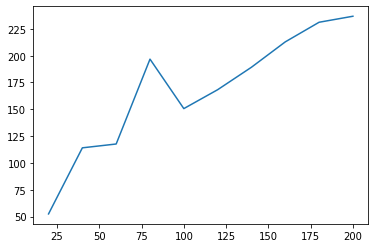

In [14]:
lda_train_time = np.array([3152, 6847, 7061, 11806, 9040, 10096, 11353, 12771, 13868, 14204])/60
plt.plot(range(20, 201, 20), lda_train_time)

#### LDA with Logistic

In [15]:
def testLdaTopics():
    res_lda_top = {}

    for topics in range(20, 201, 20):
        print(topics)
        tst = time.time()
        
        mod = loadLdaModel("PTitCon", topics)
        tr_lda, val_lda, _ = loadLdaFeatures("PTitCon", topics)
        

        lr_clf = LogisticRegression(random_state=1234, solver="saga")
        lr_clf.fit(tr_lda, train.publication)

        a = pd.DataFrame({"act":train.publication, "pred":lr_clf.predict(tr_lda)})
        tr_acc = sum(a.act == a.pred)/len(a)
        tr_f1 = f1_score(a.act, a.pred, average="weighted")

        a = pd.DataFrame({"act":validation.publication, "pred":lr_clf.predict(val_lda)})
        val_acc = sum(a.act == a.pred)/len(a)
        val_f1 = f1_score(a.act, a.pred, average="weighted")

        res_lda_top[topics] = (tr_acc, tr_f1, val_acc, val_f1, time.time()-tst)
        print(topics, res_lda_top[topics])

        del a, tr_acc, tr_f1, val_acc, val_f1, tr_lda, val_lda, mod
    return res_lda_top

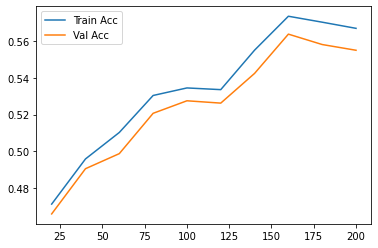

In [17]:
if os.path.exists("results_lda_topics_sel.csv"):
    res_lda_top_df = pd.read_csv("results_lda_topics_sel.csv", index_col=0)
else:
    res_lda_top = testLdaTopics()
    res_lda_top_df = pd.DataFrame(res_lda_top).transpose()
    res_lda_top_df.columns = ["Train Acc", "Train F1", "Val Acc", "Val F1", "Time to train"]
    res_lda_top_df.to_csv("results_lda_topics_sel.csv")

res_lda_top_df.drop(["Time to train", "Train F1", "Val F1"], axis=1).plot()

#### LDA with SVM

In [32]:
from sklearn.svm import SVC

def testLdaTopicsSVM(st=20, en=201, stp=20):
    res_lda_top = {}

    for topics in range(st, en, stp):
        print(topics)
        tst = time.time()
        
        mod = loadLdaModel("PTitCon", topics)
        tr_lda, val_lda, _ = loadLdaFeatures("PTitCon", topics)
        

        sv_clf = SVC(kernel="linear")
        sv_clf.fit(tr_lda, train.publication)

        a = pd.DataFrame({"act":train.publication, "pred":sv_clf.predict(tr_lda)})
        tr_acc = sum(a.act == a.pred)/len(a)
        tr_f1 = f1_score(a.act, a.pred, average="weighted")

        a = pd.DataFrame({"act":validation.publication, "pred":sv_clf.predict(val_lda)})
        val_acc = sum(a.act == a.pred)/len(a)
        val_f1 = f1_score(a.act, a.pred, average="weighted")

        res_lda_top[topics] = (tr_acc, tr_f1, val_acc, val_f1, time.time()-tst)
        print(topics, res_lda_top[topics])

        del a, tr_acc, tr_f1, val_acc, val_f1, tr_lda, val_lda, mod, sv_clf
    return res_lda_top

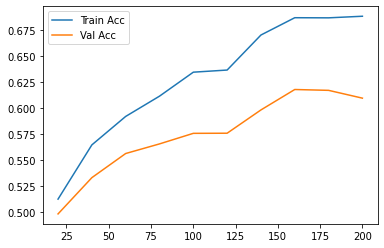

In [30]:
if os.path.exists("results_lda_svm_topics_sel.csv"):
    res_lda_svm_top_df = pd.read_csv("results_lda_svm_topics_sel.csv", index_col=0)
else:
    res_lda_svm_top = testLdaTopicsSVM()
    res_lda_svm_top_df = pd.DataFrame(res_lda_svm_top).transpose()
    res_lda_svm_top_df.columns = ["Train Acc", "Train F1", "Val Acc", "Val F1", "Time to train"]
    res_lda_svm_top_df.to_csv("results_lda_svm_topics_sel.csv")

res_lda_svm_top_df.drop(["Time to train", "Train F1", "Val F1"], axis=1).plot()

## Generate Vocabulary

In [18]:
def genVocab(articles):
    global wordsCount
    for art in articles:
        docWords = set()
        for word in art.split():
            try:
                wordsCount[word][0] += 1
                if word not in docWords:
                    wordsCount[word][1] += 1
                    docWords.add(word)
            except:
                wordsCount[word] = [1, 1]

In [19]:
wordsCount = {}
genVocab(train.PTitCon.to_list())
wordsCount = pd.DataFrame({"Words":list(wordsCount.keys()), "WordCount":list(wordsCount.values())})
wordsCount[['Count','DocCount']] = pd.DataFrame(wordsCount.WordCount.values.tolist(), index= wordsCount.index)
wordsCount.drop("WordCount", axis=1, inplace=True)

Count of unique words in the text fields of the datset.

In [20]:
len(wordsCount)

141803

Top 10 words that occur in most of the documents.

In [21]:
wordsCount.sort_values(by="DocCount", ascending=False)[:10]

,Words,Count,DocCount
41,said,181723,27210
412,one,70408,25187
32,year,66204,23641
763,would,69868,22825
73,also,48689,22805
292,time,50565,21815
85,new,55649,21279
440,people,67505,21188
311,say,70924,19492
241,could,41091,19100


Top 10 words that occur most number of times in the data corpus.

In [22]:
wordsCount.sort_values(by="Count", ascending=False)[:10]

,Words,Count,DocCount
41,said,181723,27210
190,trump,120540,13224
311,say,70924,19492
412,one,70408,25187
763,would,69868,22825
440,people,67505,21188
32,year,66204,23641
350,state,63364,18274
85,new,55649,21279
292,time,50565,21815


## TF-IDF

#### Selecting max features for TF-IDF

#### TF-IDF with Logistic

In [23]:
#arguments will be multiplied by 1000
def testTfIdfMaxf(start=1, end=31, step=1):
    res_tf_fet = {}

    for i in range(start, end, step):
        print(i*1000)
        tst = time.time()
        tf = TfidfVectorizer(max_features=i*1000, ngram_range=(1,3))
        train_tf = tf.fit_transform(train.PTitCon).todense()
        val_tf = tf.transform(validation.PTitCon).todense()

        lr_clf = LogisticRegression(random_state=1234, solver="saga")
        lr_clf.fit(train_tf, train.publication)

        a = pd.DataFrame({"act":train.publication, "pred":lr_clf.predict(train_tf)})
        tr_acc = sum(a.act == a.pred)/len(a)
        tr_f1 = f1_score(a.act, a.pred, average="weighted")

        a = pd.DataFrame({"act":validation.publication, "pred":lr_clf.predict(val_tf)})
        val_acc = sum(a.act == a.pred)/len(a)
        val_f1 = f1_score(a.act, a.pred, average="weighted")

        res_tf_fet[i*1000] = (tr_acc, tr_f1, val_acc, val_f1, time.time()-tst)
        print(i, res_tf_fet[i*1000])

        del a, tr_acc, val_acc, tr_f1, val_f1, train_tf, val_tf, tf
    return res_tf_fet

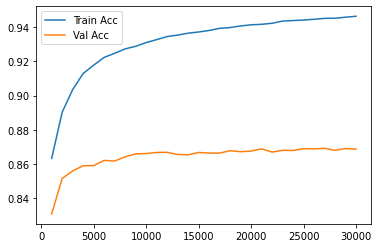

In [25]:
if os.path.exists("results_tf_fet_sel.csv"):
    res_tf_fet_df = pd.read_csv("results_tf_fet_sel.csv", index_col=0)
else:
    res_tf_fet = testTfIdfMaxf(1,31)
    res_tf_fet_df = pd.DataFrame(res_tf_fet).transpose()
    res_tf_fet_df.columns = ["Train Acc", "Train F1", "Val Acc", "Val F1", "Time to train"]
    res_tf_fet_df.to_csv("results_tf_fet_sel.csv")
    res_tf_fet_df.drop(["Time to train", "Train F1", "Val F1"], axis=1).plot()

res_tf_fet_df.drop(["Time to train", "Train F1", "Val F1"], axis=1).plot()

#### TF-IDF with SVM

In [42]:
#arguments will be multiplied by 1000
def testTfIdfMaxfSVM(start=1, end=31, step=1):
    res_tf_svm_fet = {}

    for i in range(start, end, step):
        print(i*1000)
        tst = time.time()
        tf = TfidfVectorizer(max_features=i*1000, ngram_range=(1,3))
        train_tf = tf.fit_transform(train.PTitCon).todense()
        val_tf = tf.transform(validation.PTitCon).todense()

        sv_clf = SVC(kernel="linear")
        sv_clf.fit(train_tf, train.publication)

        a = pd.DataFrame({"act":train.publication, "pred":sv_clf.predict(train_tf)})
        tr_acc = sum(a.act == a.pred)/len(a)
        tr_f1 = f1_score(a.act, a.pred, average="weighted")

        a = pd.DataFrame({"act":validation.publication, "pred":sv_clf.predict(val_tf)})
        val_acc = sum(a.act == a.pred)/len(a)
        val_f1 = f1_score(a.act, a.pred, average="weighted")

        res_tf_svm_fet[i*1000] = (tr_acc, tr_f1, val_acc, val_f1, time.time()-tst)
        print(i, res_tf_svm_fet[i*1000])

        del a, tr_acc, val_acc, tr_f1, val_f1, train_tf, val_tf, tf
    return res_tf_svm_fet

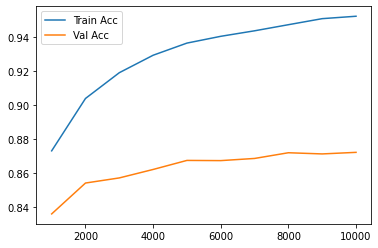

In [45]:
if os.path.exists("results_tf_svm_fet_sel.csv"):
    res_tf_svm_fet_df = pd.read_csv("results_tf_svm_fet_sel.csv", index_col=0)
else:
    res_tf_svm_fet = testTfIdfMaxfSVM(1,11)
    res_tf_svm_fet_df = pd.DataFrame(res_tf_svm_fet).transpose()
    res_tf_svm_fet_df.columns = ["Train Acc", "Train F1", "Val Acc", "Val F1", "Time to train"]
    res_tf_svm_fet_df.to_csv("results_tf_svm_fet_sel.csv")

res_tf_svm_fet_df.drop(["Time to train", "Train F1", "Val F1"], axis=1).plot()

## Visualize Results

#### TF-IDF number of features selection

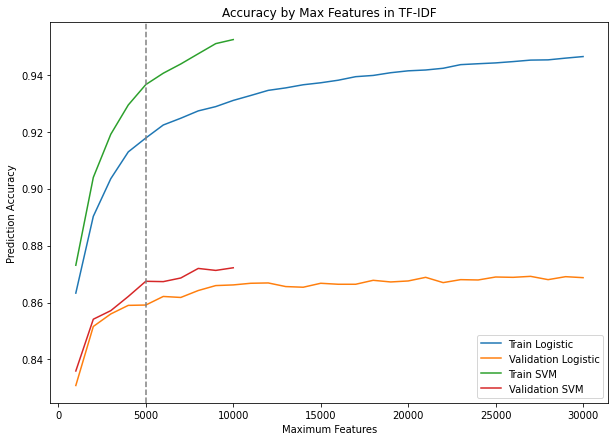

In [71]:
res1 = pd.read_csv("results_tf_fet_sel.csv", index_col=0).drop(["Train F1", "Val F1", "Time to train"], axis=1)
res1.columns = ["Train Logistic", "Validation Logistic"]
res2 = pd.read_csv("results_tf_svm_fet_sel.csv", index_col=0).drop(["Train F1", "Val F1", "Time to train"], axis=1)
res2.columns = ["Train SVM", "Validation SVM"]
res = pd.concat([res1, res2])
ax = res.plot(title="Accuracy by Max Features in TF-IDF", figsize=(10,7))
ax.set_xlabel("Maximum Features")
ax.set_ylabel("Prediction Accuracy")
ax.axvline(5000, color='gray', linestyle='--')
ax.get_figure().savefig("tfidf_fet_sel.png")

#### LDA number of topics selection

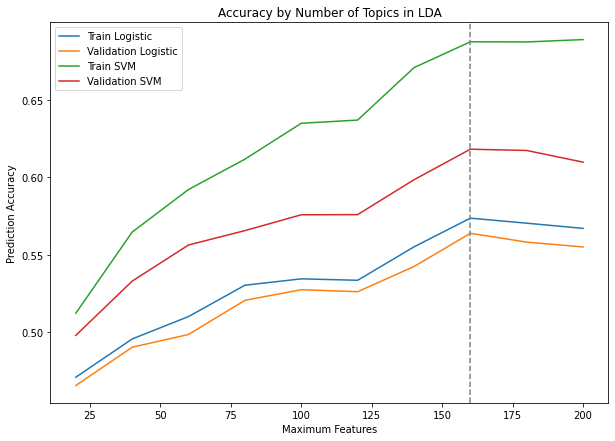

In [56]:
res1 = pd.read_csv("results_lda_topics_sel.csv", index_col=0).drop(["Train F1", "Val F1", "Time to train"], axis=1)
res1.columns = ["Train Logistic", "Validation Logistic"]
res2 = pd.read_csv("results_lda_svm_topics_sel.csv", index_col=0).drop(["Train F1", "Val F1", "Time to train"], axis=1)
res2.columns = ["Train SVM", "Validation SVM"]
res = pd.concat([res1, res2])
ax = res.plot(title="Accuracy by Number of Topics in LDA", figsize=(10,7))
ax.set_xlabel("Maximum Features")
ax.set_ylabel("Prediction Accuracy")
ax.axvline(160, color='gray', linestyle='--')
ax.get_figure().savefig("lda_top_sel.png")

#### Visualize LDA topics

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random

def plot_docs(numTopics=40, name=""):
    doc_vecs = loadPickle("Data/ExtractedFeaturesPickles/PTitCon"+str(numTopics)+"_tr")
    doc_class = []
    inds = []
    classes = train.publication.unique()
    for cl in classes:
        sam = train[train.publication == cl].index.to_list()
        inds.extend(random.sample(sam, 200))
    docs = np.array(doc_vecs[inds])
    n = len(inds)
    #docs = random.sample(train_vecs, n)
    dvm = np.zeros((n, doc_vecs.shape[1]))
    c = 0
    for doc in docs:
        _ = doc.reshape(doc_vecs.shape[1],1)
        dvm[c,:] = doc
        doc_class.append(train.iloc[inds[c]].publication)
        c += 1
    red_dvm = TSNE(n_components=2, random_state=1234).fit_transform(dvm)
    df = pd.DataFrame({"x":red_dvm[:, 0], "y":red_dvm[:, 1], "label":doc_class})
    
    sns.scatterplot(x="x", y="y", hue="label", data=df)
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if name != "":
        plt.savefig(name+".png", bbox_extra_artists=(lgd, ), bbox_inches='tight')
    plt.show()

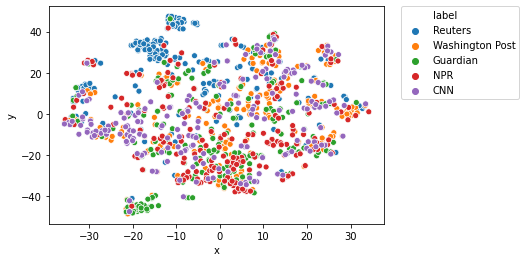

In [69]:
plot_docs(160, "lda160_viz.png")

## Best Classifiers Results

In [75]:
def checkPreformance(mod, tr, val, te):
    a = pd.DataFrame({"act":train.publication, "pred":mod.predict(tr)})
    tr_acc = sum(a.act == a.pred)/len(a)
    tr_f1 = f1_score(a.act, a.pred, average="weighted")
    print("Training Dataset Accuracy :", tr_acc)
    print("Training Dataset F1 :", tr_f1)

    a = pd.DataFrame({"act":validation.publication, "pred":mod.predict(val)})
    val_acc = sum(a.act == a.pred)/len(a)
    val_f1 = f1_score(a.act, a.pred, average="weighted")
    print("Validation Dataset Accuracy :", val_acc)
    print("Validation Dataset F1 :", val_f1)
    
    a = pd.DataFrame({"act":test.publication, "pred":mod.predict(te)})
    te_acc = sum(a.act == a.pred)/len(a)
    te_f1 = f1_score(a.act, a.pred, average="weighted")
    print("Test Dataset Accuracy :", te_acc)
    print("Test Dataset F1 :", te_f1)

#### LDA

In [77]:
tr_lda, val_lda, te_lda = loadLdaFeatures("PTitCon", 160)

###### Logistic

In [78]:
lr_clf_lda = LogisticRegression(random_state=1234, solver="saga")
lr_clf_lda.fit(tr_lda, train.publication)
checkPreformance(lr_clf_lda, tr_lda, val_lda, te_lda)

Training Dataset Accuracy : 0.5736613603473227
Training Dataset F1 : 0.5694610686608421
Validation Dataset Accuracy : 0.5639036814077333
Validation Dataset F1 : 0.5602418792565961
Test Dataset Accuracy : 0.567657682689636
Test Dataset F1 : 0.564601366946962


###### SVM

In [83]:
sv_clf_lda = SVC(kernel="linear")
sv_clf_lda.fit(tr_lda, train.publication)
checkPreformance(sv_clf_lda, tr_lda, val_lda, te_lda)

Training Dataset Accuracy : 0.6872937771345875
Training Dataset F1 : 0.6856639542182597
Validation Dataset Accuracy : 0.618082889557768
Validation Dataset F1 : 0.6180557031897302
Test Dataset Accuracy : 0.6213763082337687
Test Dataset F1 : 0.6205345683639447


#### TF-IDF

In [88]:
tf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
train_tf = tf.fit_transform(train.PTitCon).todense()
val_tf = tf.transform(validation.PTitCon).todense()
test_tf = tf.transform(test.PTitCon).todense()

###### Logistic

In [89]:
lr_clf_tf = LogisticRegression(random_state=1234, solver="saga")
lr_clf_tf.fit(train_tf, train.publication)
checkPreformance(lr_clf_tf, train_tf, val_tf, test_tf)

Training Dataset Accuracy : 0.9177424023154848
Training Dataset F1 : 0.9178692540309259
Validation Dataset Accuracy : 0.8591109053021533
Validation Dataset F1 : 0.859233439736964
Test Dataset Accuracy : 0.8713531536537927
Test Dataset F1 : 0.8716858883034857


###### SVM

In [82]:
#sv_clf_lda = SVC(kernel="linear")
#sv_clf_lda.fit(train_tf, train.publication)
#checkPreformance(sv_clf_lda, train_tf, val_tf, test_tf)

print("Train Dataset Accuracy :", 0.9364978292329956)
print("Train Dataset F1 :", 0.9365794119766288)
print("Validation Dataset Accuracy :", 0.8674461680944663)
print("Validation Dataset F1 :", 0.8679231355286984)
print("Test Dataset Accuracy :", 0.8778364360470501)
print("Test Dataset F1 :", 0.8783547363662094)

Train Dataset Accuracy : 0.9364978292329956
Train Dataset F1 : 0.9365794119766288
Validation Dataset Accuracy : 0.8674461680944663
Validation Dataset F1 : 0.8679231355286984
Test Dataset Accuracy : 0.8778364360470501
Test Dataset F1 : 0.8783547363662094


In [103]:
pd.DataFrame({"Words":list(tf.vocabulary_.keys()), "Ind":list(tf.vocabulary_.values())}).head()

,Words,Ind
0,post,3296
1,strong,4260
2,first,1692
3,quarter,3482
4,sale,3845


#### TF-IDF features preform better than the LDA topics.